Import the Neccesary Libraries

In [1]:
# Import the neccesary libraries needed
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler 
import numpy as np
from numpy import insert
import os
import time

# keras tuner for hyperparameter tuning
#import keras_tuner as kt

# tensorflow Libraries
import tensorflow as tf
from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow import keras
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Activation, Dense, Dropout, LSTM
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import sparse_categorical_crossentropy
from keras.callbacks import EarlyStopping
from keras.models import load_model

Import the CSV Training and Testing Data Sets

In [2]:
# Import the csv's (IMPORTANT: You need at least 16 Gb of RAM to proceed)
train=pd.read_csv(r'C:\Users\rferr\University of Massachusetts Dartmouth\Michael R Bisbano - ECE457_Senior_Design\CSV_Files\PortTraining_1404_002_FINAL.csv')
test=pd.read_csv(r'C:\Users\rferr\University of Massachusetts Dartmouth\Michael R Bisbano - ECE457_Senior_Design\CSV_Files\StbdTesting_1404_002_FINAL.csv')

In [3]:
train

,PingNum,SampleNum,PortStbd,SampleTimeDelay,I1,Q1,I2,Q2,I3,Q3,...,I10,Q10,Roll,C,DOA,TWTT,Amplitude,AngleUncertainty,SampleRate,Range
0,87443,5,0,0.000061,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.488892,1492.040,55.809999,0.000061,0,0,65108.40625,0.045832
1,87443,6,0,0.000077,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.488892,1492.040,55.809999,0.000077,0,0,65108.40625,0.057291
2,87443,7,0,0.000092,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.488892,1492.040,55.809999,0.000092,0,0,65108.40625,0.068749
3,87443,8,0,0.000108,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.488892,1492.040,55.809999,0.000108,0,0,65108.40625,0.080207
4,87443,9,0,0.000123,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.488892,1492.040,55.809999,0.000123,0,0,65108.40625,0.091665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5504452,88723,4297,0,0.065982,-28.2500,24.0000,-4.6875,41.8750,23.7500,30.8125,...,-5.6875,-2.3125,1.016235,1491.949,82.134998,0.065982,76,206,65108.40625,49.221089
5504453,88723,4298,0,0.065998,-70.8750,26.7500,7.2500,78.1250,66.7500,30.7500,...,-43.3125,-50.6875,1.016235,1491.949,80.939998,0.065998,84,97,65108.40625,49.232546
5504454,88723,4299,0,0.066013,-42.5625,15.3750,14.5625,48.1875,42.7500,7.6250,...,-46.6875,-43.5000,1.016235,1491.949,80.624998,0.066013,96,32,65108.40625,49.244004
5504455,88723,4300,0,0.066028,35.9375,-15.7500,13.1875,-39.5000,-40.5625,-27.1250,...,1.4375,16.5625,1.016235,1491.949,80.924998,0.066028,90,48,65108.40625,49.255461


In [5]:
test

,PingNum,SampleNum,PortStbd,SampleTimeDelay,I1,Q1,I2,Q2,I3,Q3,...,I10,Q10,Roll,C,DOA,TWTT,Amplitude,AngleUncertainty,SampleRate,Range
0,87443,24,1,0.000353,0.0625,0.0000,0.3125,-0.1875,0.3750,-0.3750,...,0.1875,0.0000,0.488892,1492.040,55.834999,0.000353,0,180,65108.40625,0.263537
1,87443,25,1,0.000369,0.0000,-0.0625,-0.2500,-0.3125,-0.4375,-0.4375,...,0.0000,-0.1875,0.488892,1492.040,55.834999,0.000369,0,191,65108.40625,0.274995
2,87443,26,1,0.000384,-0.0625,0.0000,-0.3750,0.3125,-0.4375,0.5625,...,-0.2500,0.0000,0.488892,1492.040,55.834999,0.000384,0,255,65108.40625,0.286453
3,87443,27,1,0.000399,-0.0625,0.1250,0.3125,0.3750,0.5625,0.5000,...,0.0000,0.3125,0.488892,1492.040,55.834999,0.000399,12,255,65108.40625,0.297911
4,87443,28,1,0.000415,0.1250,0.1875,0.4375,-0.2500,0.5000,-0.5625,...,0.3750,0.0000,0.488892,1492.040,70.369998,0.000415,12,190,65108.40625,0.309369
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5480113,88723,4297,1,0.065982,-65.3750,46.4375,17.5625,71.1875,58.5625,22.2500,...,-68.0625,-48.0625,1.016235,1491.949,82.629998,0.065982,90,68,65108.40625,49.221089
5480114,88723,4298,1,0.065998,-13.7500,46.5000,26.4375,36.2500,45.6875,18.9375,...,-85.9375,-40.1250,1.016235,1491.949,80.584998,0.065998,98,38,65108.40625,49.232546
5480115,88723,4299,1,0.066013,52.5625,20.5000,17.0625,-21.3125,-12.0000,-5.6250,...,-26.6875,19.9375,1.016235,1491.949,79.484998,0.066013,92,93,65108.40625,49.244004
5480116,88723,4300,1,0.066028,48.0625,-5.5625,13.8750,-28.7500,-23.8750,-26.0625,...,36.2500,44.2500,1.016235,1491.949,78.554998,0.066028,82,123,65108.40625,49.255461


Split up the Features and Labels from both the Training and Testing Datasets

In [4]:
# Split up the features and labels from both the training and testing datasets
x_train=train.iloc[:,4:24]
#x_train['TWTT']=train.iloc[:,28]  I feel as though the TWTT has NO impact on the DOA so we should NOT include it in training
x_train['Amplitude']=train.iloc[:,29]


x_test=test.iloc[:,4:24]
#x_test['TWTT']=test.iloc[:,28] I feel as though the TWTT has NO impact on the DOA so we should NOT include it in training
x_test['Amplitude']=test.iloc[:,29]

y_train=train.iloc[:,26]

y_test=test.iloc[:,26]

In [7]:
y_test

0          55.834999
1          55.834999
2          55.834999
3          55.834999
4          70.369998
             ...    
5480113    82.629998
5480114    80.584998
5480115    79.484998
5480116    78.554998
5480117    81.114998
Name: DOA, Length: 5480118, dtype: float64

In [8]:
x_train

,I1,Q1,I2,Q2,I3,Q3,I4,Q4,I5,Q5,...,Q6,I7,Q7,I8,Q8,I9,Q9,I10,Q10,Amplitude
0,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
1,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
2,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
3,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
4,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5504452,-28.2500,24.0000,-4.6875,41.8750,23.7500,30.8125,42.0625,-26.6250,-6.8125,-60.3750,...,-18.4375,-22.4375,27.6875,33.4375,12.6250,18.6250,-25.0625,-5.6875,-2.3125,206
5504453,-70.8750,26.7500,7.2500,78.1250,66.7500,30.7500,58.2500,-53.7500,-36.6250,-73.9375,...,-1.8750,-21.6250,64.3125,67.5000,31.6250,46.7500,-57.0625,-43.3125,-50.6875,97
5504454,-42.5625,15.3750,14.5625,48.1875,42.7500,7.6250,14.0625,-45.5625,-50.3125,-30.6250,...,23.4375,1.0625,53.5625,44.3125,20.3750,37.2500,-45.0000,-46.6875,-43.5000,32
5504455,35.9375,-15.7500,13.1875,-39.5000,-40.5625,-27.1250,-38.9375,24.8125,22.6250,30.6875,...,-21.3750,-4.6250,-27.9375,-31.6250,7.9375,-0.6875,22.1250,1.4375,16.5625,48


Scale the Feaures from -1 to 1 so that Training is Easier for the Model

In [5]:
# Scale the Features and Labels from [-1,1]
s1=MinMaxScaler(feature_range=(-1,1))
x_train_scale=s1.fit_transform(x_train)

s2=MinMaxScaler(feature_range=(-1,1))
x_test_scale=s2.fit_transform(x_test)
x_test_scale=x_test_scale

# Scale DOA's from (0 to 1)
s3=MinMaxScaler(feature_range=(0,1))
#y_train_scale = s3.fit_transform(train[['DOA']])
y_train_scale= y_train.to_numpy()

s4=MinMaxScaler(feature_range=(0,1))
#y_test_scale = s4.fit_transform(test[['DOA']])
y_test_scale= y_test.to_numpy()

print(len(x_train_scale))
print(len(y_train_scale))

5504457
5504457


In [6]:
Test_DOA_df= pd.DataFrame(y_test_scale, columns=['TEST DOAs'])
Test_DOA_df


,TEST DOAs
0,55.834999
1,55.834999
2,55.834999
3,55.834999
4,70.369998
...,...
5480113,82.629998
5480114,80.584998
5480115,79.484998
5480116,78.554998


In [7]:
Test_DOA_df.describe()

,TEST DOAs
count,5.480118e+06
mean,6.809404e+01
std,1.517547e+01
min,-2.339000e+01
25%,6.214000e+01
50%,7.226000e+01
75%,7.793500e+01
max,1.280550e+02


In [8]:
df= pd.DataFrame(x_train_scale, columns= ['I1', 'Q1', 'I2', 'Q2', 'I3', 'Q3', 'I4', 'Q4', 'I5', 'Q5', 'I6', 'Q6', 'I7', 'Q7', 'I8', 'Q8', 'I9', 'Q9', 'I10', 'Q10', 'Amplitude'])
df


,I1,Q1,I2,Q2,I3,Q3,I4,Q4,I5,Q5,...,Q6,I7,Q7,I8,Q8,I9,Q9,I10,Q10,Amplitude
0,0.126465,0.039453,-0.081946,0.169626,-0.008040,0.072351,-0.072821,-0.014608,-0.025660,-0.024656,...,-0.005408,-0.052884,-0.020516,-0.067236,-0.119361,0.020121,-0.073706,0.132279,-0.075426,-1.000000
1,0.126465,0.039453,-0.081946,0.169626,-0.008040,0.072351,-0.072821,-0.014608,-0.025660,-0.024656,...,-0.005408,-0.052884,-0.020516,-0.067236,-0.119361,0.020121,-0.073706,0.132279,-0.075426,-1.000000
2,0.126465,0.039453,-0.081946,0.169626,-0.008040,0.072351,-0.072821,-0.014608,-0.025660,-0.024656,...,-0.005408,-0.052884,-0.020516,-0.067236,-0.119361,0.020121,-0.073706,0.132279,-0.075426,-1.000000
3,0.126465,0.039453,-0.081946,0.169626,-0.008040,0.072351,-0.072821,-0.014608,-0.025660,-0.024656,...,-0.005408,-0.052884,-0.020516,-0.067236,-0.119361,0.020121,-0.073706,0.132279,-0.075426,-1.000000
4,0.126465,0.039453,-0.081946,0.169626,-0.008040,0.072351,-0.072821,-0.014608,-0.025660,-0.024656,...,-0.005408,-0.052884,-0.020516,-0.067236,-0.119361,0.020121,-0.073706,0.132279,-0.075426,-1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5504452,0.121114,0.044620,-0.083122,0.178632,-0.002254,0.079035,-0.063930,-0.020709,-0.027349,-0.039358,...,-0.009766,-0.058393,-0.013365,-0.058956,-0.116415,0.024596,-0.079996,0.130999,-0.075983,0.615686
5504453,0.113040,0.045212,-0.080127,0.186429,0.008223,0.079022,-0.060508,-0.026925,-0.034740,-0.042661,...,-0.005851,-0.058193,-0.003906,-0.050520,-0.111983,0.031353,-0.088027,0.122531,-0.087641,-0.239216
5504454,0.118403,0.042763,-0.078292,0.179990,0.002376,0.074005,-0.069849,-0.025049,-0.038134,-0.032114,...,0.000133,-0.052623,-0.006683,-0.056262,-0.114607,0.029071,-0.085000,0.121772,-0.085909,-0.749020
5504455,0.133273,0.036062,-0.078637,0.161131,-0.017923,0.066466,-0.081052,-0.008922,-0.020051,-0.017183,...,-0.010461,-0.054019,-0.027732,-0.075068,-0.117509,0.019956,-0.068154,0.132603,-0.071435,-0.623529


In [13]:
df.describe()

,I1,Q1,I2,Q2,I3,Q3,I4,Q4,I5,Q5,...,Q6,I7,Q7,I8,Q8,I9,Q9,I10,Q10,Amplitude
count,5.504457e+06,5.504457e+06,5.504457e+06,5.504457e+06,5.504457e+06,5.504457e+06,5.504457e+06,5.504457e+06,5.504457e+06,5.504457e+06,...,5.504457e+06,5.504457e+06,5.504457e+06,5.504457e+06,5.504457e+06,5.504457e+06,5.504457e+06,5.504457e+06,5.504457e+06,5.504457e+06
mean,1.264778e-01,3.947868e-02,-8.194078e-02,1.696534e-01,-8.030354e-03,7.240320e-02,-7.282897e-02,-1.455575e-02,-2.568082e-02,-2.460683e-02,...,-5.374336e-03,-5.291370e-02,-2.052685e-02,-6.724462e-02,-1.193843e-01,2.014490e-02,-7.372333e-02,1.322834e-01,-7.543048e-02,-2.842445e-01
std,4.173832e-02,4.735650e-02,5.484312e-02,4.701740e-02,5.302079e-02,4.711205e-02,4.642880e-02,5.031420e-02,5.382881e-02,5.293257e-02,...,5.209302e-02,5.393893e-02,5.669476e-02,5.302742e-02,4.998064e-02,5.144605e-02,5.363648e-02,5.004921e-02,5.371041e-02,6.070430e-01
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,...,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00,-1.000000e+00
25%,1.159875e-01,2.753108e-02,-9.599523e-02,1.576224e-01,-2.174575e-02,6.013396e-02,-8.487026e-02,-2.766957e-02,-3.969877e-02,-3.841471e-02,...,-1.876422e-02,-6.648046e-02,-3.481784e-02,-8.084138e-02,-1.321630e-01,6.366749e-03,-8.807429e-02,1.188460e-01,-8.982469e-02,-7.254902e-01
50%,1.264651e-01,3.945315e-02,-8.194562e-02,1.696262e-01,-8.040446e-03,7.235058e-02,-7.282143e-02,-1.460816e-02,-2.566010e-02,-2.465603e-02,...,-5.407642e-03,-5.288358e-02,-2.051621e-02,-6.723626e-02,-1.193608e-01,2.012133e-02,-7.370634e-02,1.322793e-01,-7.542623e-02,-5.215686e-01
75%,1.369545e-01,5.137521e-02,-6.789601e-02,1.816569e-01,5.710544e-03,8.459432e-02,-6.075939e-02,-1.489459e-03,-1.162142e-02,-1.085170e-02,...,7.978488e-03,-3.930205e-02,-6.214589e-03,-5.367756e-02,-1.065877e-01,3.386089e-02,-5.938544e-02,1.456563e-01,-6.107296e-02,-5.098039e-02
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,...,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


Shift the DOA's to the Left by one so that the Current I and Q data Align with the current DOA while using TimeSeriesGenerator to Window the Data

In [9]:
# Shift the DOA to the left by one to use the current DOA label with the current I and Q data.
# Normally the TimeseriesGenerator function uses past values to predict the future but we would like current data to help predict the current samples' DOA
print(len(x_train_scale))
print(len(y_test_scale))
y_train_scale=insert(y_train_scale, 0, 0)
y_train_scale=np.delete(y_train_scale, -1)
y_test_scale=insert(y_test_scale, 0,0)
y_test_scale=np.delete(y_test_scale, -1)
print(y_train_scale)
print(len(y_train_scale))
print(y_test_scale)
print(len(y_test_scale))

5504457
5480118
[ 0.         55.80999875 55.80999875 ... 80.93999819 80.6249982
 80.92499819]
5504457
[ 0.         55.83499875 55.83499875 ... 80.5849982  79.48499822
 78.55499824]
5480118


Create the Windows Neccesary for the LSTM model using the TimeSeriesGenerator Function

In [19]:
# Create the windows neccesary for the LSTM model within tensorflow keras
# Below are the arguments of the timeseries_dataset_from_array function
# The function takes a numpy array and makes a timeseries out of it
NumSampsPerPing= 4297
data=x_train_scale # the data to make the windows
targets=y_train_scale # time steps in the data (don't need)
sequence_length=10 # window length
sequence_stride=1# period between successive output sequences
sampling_rate=1 # period between successive individual timesteps     within sequences
batch_size=NumSampsPerPing # number of time series samples in each batch
shuffle=False #shuffle the data before making the windows
seed=None # is related to shuffle
start_index=None # is related to shuffle
end_index=None # is related to shuffle
n_features=21

test_data=x_test_scale
test_targets=y_test_scale

inputs=TimeseriesGenerator(data=data, targets=targets,length=sequence_length, sampling_rate=sampling_rate,stride=sequence_stride, batch_size= batch_size)
#test_inputs=TimeseriesGenerator(test_data[0:40000], -1*test_targets[0:40000],sequence_length, batch_size)
test_inputs=TimeseriesGenerator(data=test_data, targets=test_targets,length=sequence_length, sampling_rate=sampling_rate,stride=sequence_stride, batch_size= batch_size)
#inputs=tf.keras.preprocessing.timeseries_dataset_from_array(data, targets, sequence_length, sequence_stride, sampling_rate, batch_size, shuffle)
#print(type(inputs))

print('done')

done


In [22]:
# print the first couple of samples to see if everything everything is lining up
for i in range(100):
	x, y = inputs[i]
	print('%s => %s' % (x, y))

[[[ 0.12646509  0.03945315 -0.08194562 ...  0.1322793  -0.07542623
   -1.        ]
  [ 0.12646509  0.03945315 -0.08194562 ...  0.1322793  -0.07542623
   -1.        ]
  [ 0.12646509  0.03945315 -0.08194562 ...  0.1322793  -0.07542623
   -1.        ]
  ...
  [ 0.12646509  0.03945315 -0.08194562 ...  0.1322793  -0.07542623
   -1.        ]
  [ 0.12646509  0.03945315 -0.08194562 ...  0.1322793  -0.07542623
   -1.        ]
  [ 0.12646509  0.03945315 -0.08194562 ...  0.1322793  -0.07542623
   -1.        ]]

 [[ 0.12646509  0.03945315 -0.08194562 ...  0.1322793  -0.07542623
   -1.        ]
  [ 0.12646509  0.03945315 -0.08194562 ...  0.1322793  -0.07542623
   -1.        ]
  [ 0.12646509  0.03945315 -0.08194562 ...  0.1322793  -0.07542623
   -1.        ]
  ...
  [ 0.12646509  0.03945315 -0.08194562 ...  0.1322793  -0.07542623
   -1.        ]
  [ 0.12646509  0.03945315 -0.08194562 ...  0.1322793  -0.07542623
   -1.        ]
  [ 0.12646509  0.03945315 -0.08194562 ...  0.1322793  -0.07542623
   -1.

In [19]:
# print the first couple of samples to see if everything everything is lining up
for i in range(100):
	x, y = test_inputs[i]
	print('%s => %s' % (x, y))

[[[ 0.01588116 -0.18096586 -0.05335147 ...  0.03537926  0.16587978
    0.41176471]
  [ 0.015868   -0.18097849 -0.05349056 ...  0.0353361   0.1658366
    0.49803922]
  [ 0.01585485 -0.18096586 -0.05352148 ...  0.03527855  0.16587978
    1.        ]
  ...
  [ 0.0157759  -0.18096586 -0.05345965 ...  0.0353361   0.16596614
   -0.11372549]
  [ 0.01585485 -0.18086477 -0.05339783 ...  0.03540803  0.16586538
   -0.39607843]
  [ 0.01597326 -0.18092795 -0.05333601 ...  0.03529293  0.1658366
   -0.08235294]]

 [[ 0.015868   -0.18097849 -0.05349056 ...  0.0353361   0.1658366
    0.49803922]
  [ 0.01585485 -0.18096586 -0.05352148 ...  0.03527855  0.16587978
    1.        ]
  [ 0.01585485 -0.18094059 -0.05335147 ...  0.0353361   0.16595175
    1.        ]
  ...
  [ 0.01585485 -0.18086477 -0.05339783 ...  0.03540803  0.16586538
   -0.39607843]
  [ 0.01597326 -0.18092795 -0.05333601 ...  0.03529293  0.1658366
   -0.08235294]
  [ 0.01592063 -0.18104167 -0.05341329 ...  0.03532171  0.16596614
    0.7411

Define the Model's Structure

In [27]:
# With all the preproccessing done, it is time to define the model
# Define the LSTM Model
model= Sequential()
model.add(LSTM(units=64, activation='tanh', input_shape=(sequence_length,n_features), return_sequences=True))
model.add(Dense(units=100))
model.add(Dropout(0.2))

model.add(LSTM(units=416, activation='tanh', return_sequences=True))
model.add(Dense(units=100))
model.add(Dropout(0.2))

model.add(LSTM(units=512))
model.add(Dense(units=100))
model.add(Dropout(0.2))


#model.add(LSTM(units=320, activation='tanh', return_sequences=True))
#model.add(Dropout(0.2))

#model.add(LSTM(units=480))
#model.add(Dropout(0.2))


model.add(Dense(units=1)) #one output (namely: DOA)


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 10, 64)            22016     
                                                                 
 dense (Dense)               (None, 10, 100)           6500      
                                                                 
 dropout (Dropout)           (None, 10, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 10, 416)           860288    
                                                                 
 dense_1 (Dense)             (None, 10, 100)           41700     
                                                                 
 dropout_1 (Dropout)         (None, 10, 100)           0         
                                                                 
 lstm_2 (LSTM)               (None, 512)               1

Train the Model using the Specified Hyperparmeters

In [21]:
def scheduler(epoch,lr):
    if epoch>=1:
        return lr
    elif epoch>=2 | epoch<=4:
        return lr/1.65
    else:
        return lr * tf.math.exp(-.5)


Epoch 1/10
1281/1281 [==============================] - 162s 124ms/step - loss: 1563.2458 - lr: 6.0653e-06
Epoch 2/10
1281/1281 [==============================] - 162s 126ms/step - loss: 298.8187 - lr: 6.0653e-06
Epoch 3/10
1281/1281 [==============================] - 167s 130ms/step - loss: 259.5406 - lr: 6.0653e-06
Epoch 4/10
1281/1281 [==============================] - 164s 128ms/step - loss: 237.3898 - lr: 6.0653e-06
Epoch 5/10
1281/1281 [==============================] - 161s 126ms/step - loss: 230.1006 - lr: 6.0653e-06
Epoch 6/10
1281/1281 [==============================] - 164s 128ms/step - loss: 224.4170 - lr: 6.0653e-06
Epoch 7/10
1281/1281 [==============================] - 158s 123ms/step - loss: 219.1565 - lr: 6.0653e-06
Epoch 8/10
1281/1281 [==============================] - 159s 124ms/step - loss: 213.9459 - lr: 6.0653e-06
Epoch 9/10
1281/1281 [==============================] - 159s 124ms/step - loss: 209.0706 - lr: 6.0653e-06
Epoch 10/10
1281/1281 [======================

Text(0, 0.5, 'loss')

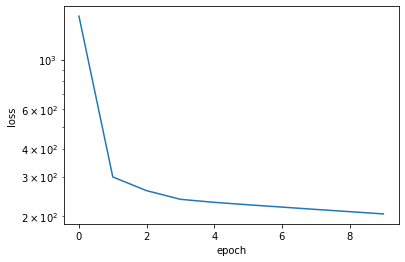

In [28]:
#Now it is time to train the model
opt=tf.keras.optimizers.Adam(learning_rate=.00001)#,decay=.97)
model.compile(loss='mean_squared_error', optimizer=opt)#metrics=['mean_squared_error','binary_crossentropy'])


sc = tf.keras.callbacks.LearningRateScheduler(scheduler)

# Allow for early stopping so that the model does not overfit the training dataset
es= EarlyStopping(monitor='loss', mode='min',verbose=1,patience=10)

#t0=time.time()
#history= model.fit(inputs,steps_per_epoch=4000,epochs=200,verbose=1, callbacks=[es])
history= model.fit(inputs,epochs=10,batch_size=None,callbacks=[sc])
#t1=time.time()
#print("The total run time to train was %.2f seconds"%(t1-t0))

# plot the loss function
plt.figure()
plt.semilogy(history.history['loss'])
plt.xlabel('epoch'); plt.ylabel('loss')


Using the Model, Predict the DOA's on the Testing Dataset

In [29]:
#use the model to predict on the testing dataset
#for right now test_inputs has only the 40,001 samples
predicted=model.predict(test_inputs, verbose=1)

1276/1276 [==============================] - 56s 43ms/step


In [30]:
print(predicted[10:21])

[[78.24661 ]
 [78.22801 ]
 [78.163605]
 [78.174614]
 [78.1384  ]
 [78.07472 ]
 [78.142265]
 [78.18408 ]
 [78.19272 ]
 [78.22133 ]
 [78.252625]]


In [31]:
print(y_test[10:21])

10    75.344998
11    49.974999
12    50.274999
13    62.839999
14    61.619999
15    75.429998
16    76.294998
17    62.244999
18    57.394999
19    59.214999
20    61.579999
Name: DOA, dtype: float64


In [32]:
type(predicted)
predicted.shape

(5480108, 1)

In [33]:
predicted_reshape= predicted.reshape(len(predicted),1)

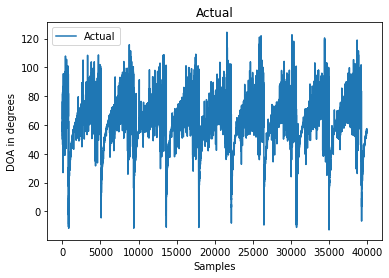

In [276]:
plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual'])
plt.show()


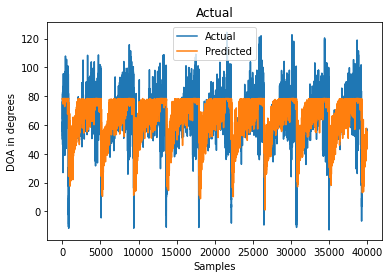

In [34]:
plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.plot(predicted_reshape[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()



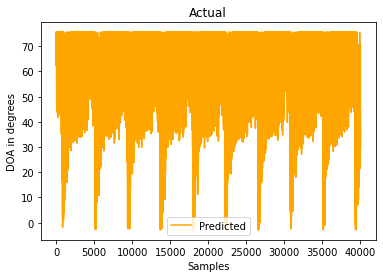

In [175]:
plt.figure(facecolor='white')
plt.plot(predicted[0:40000], 'orange')
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Predicted'])
plt.show()

Compare the Actual Testing DOA's to the Predicted DOA's

In [ ]:
plt.rcParams.update(plt.rcParamsDefault)


plt.figure(facecolor='white')
plt.plot(y_test[0:10], '.')
plt.plot(predicted[0:10], '.')
plt.title("Actual")
plt.legend(['Actual','Predicted'])
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.show()

plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.plot(predicted_reshape[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual','Predicted'])
plt.show()


plt.figure(facecolor='white')
plt.plot(y_test[0:40000])
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Actual'])
plt.show()


plt.figure(facecolor='white')
plt.plot(predicted_reshape[0:40000], 'orange')
plt.title("Actual")
plt.xlabel('Samples')
plt.ylabel('DOA in degrees')
plt.legend(['Predicted'])
plt.show()


In [ ]:
print(y_test[0:50000])


In [ ]:
df2= pd.DataFrame(predicted, columns= ['DOA'])
df2

EVERYTHING BELOW HERE IS MY KERAS TUNER STUFF. VIEWER REGRESSION IS ADVISED.

In [ ]:
LOG_DIR = f"{int(time.time())}"

In [ ]:
def model_builder(hp):
    model= Sequential()

    #try
    hp_units_1 = hp.Int('units1', min_value=32, max_value=512, step=32)
    model.add(LSTM(units=hp_units_1, activation='tanh', input_shape=(sequence_length,n_features), return_sequences=True))
    model.add(Dropout(0.2))

    for i in range(hp.Int("n_layers",1,2)):
        model.add(LSTM(units=hp.Int(f"LSTM_{i}_units", min_value=32, max_value=512, step=32), activation='tanh', input_shape=(sequence_length,n_features), return_sequences=True))
        model.add(Dropout(0.2))

    #hp_units_2 = hp.Int('units2', min_value=32, max_value=512, step=32)
    #model.add(LSTM(units=hp_units_2, activation='relu',  return_sequences=True))
    #model.add(Dropout(0.2))

    #hp_units_3 = hp.Int('units3', min_value=32, max_value=512, step=32)
    #model.add(LSTM(units=hp_units_3, activation='relu', return_sequences=True))
    #model.add(Dropout(0.2))

    #hp_units_4 = hp.Int('units4', min_value=32, max_value=512, step=32)
    #model.add(LSTM(units=hp_units_4, activation='relu',  return_sequences=True))
    #model.add(Dropout(0.2))

    model.add(Dense(units=1)) #one output (namely: DOA)

    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    opt=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate,decay=1e-5)
    model.compile(loss='mse', optimizer=opt)

    return model

In [ ]:
es= EarlyStopping(monitor='loss', mode='min',verbose=1,patience=10)

tuner = kt.RandomSearch(model_builder, objective='loss', max_trials=1000, directory=os.path.normpath('C:/'))
tuner.search(inputs,steps_per_epoch=2000,epochs=20,verbose=1, callbacks=[es])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]


print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units1')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}. 
""")

In [ ]:
print(f"""
Unit1: {best_hps.get('units1')} learning rate {best_hps.get('learning_rate')} LSTM0 units: {best_hps.get('LSTM_0_units')} LSTM1 units: {best_hps.get('LSTM_1_units')} 
""")

Put the predicted DOA's back into a csv file format

In [35]:
#Ping |  Num Samp Num | PORT or STBD (0 or 1) |  TWTT |  Predicted DOA   <=======Output columns.
OutputCSVdf=test.iloc[:,[0,1,2,3]]
#OutputCSVdf= pd.DataFrame(test.iloc[:,[0,1,2,3]], columns=['PingNumber','SampNumber','PortStbd', 'SampleTime'])
zerosArray= np.arange(sequence_length)*0
predictedShifted=np.append(zerosArray, predicted)
Predicteddf= pd.DataFrame(predictedShifted,columns=['PredictedDOA'])
OutputCSVdf=OutputCSVdf.join(Predicteddf)

In [36]:
test.iloc[:,[0,1,2,3]]

,PingNum,SampleNum,PortStbd,SampleTimeDelay
0,87443,24,1,0.000353
1,87443,25,1,0.000369
2,87443,26,1,0.000384
3,87443,27,1,0.000399
4,87443,28,1,0.000415
...,...,...,...,...
5480113,88723,4297,1,0.065982
5480114,88723,4298,1,0.065998
5480115,88723,4299,1,0.066013
5480116,88723,4300,1,0.066028


In [37]:
zerosArray= np.arange(sequence_length)*0
zerosArray

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [38]:
predictedShifted=np.append(zerosArray, predicted)
predictedShifted

array([ 0.        ,  0.        ,  0.        , ..., 75.63926697,
       73.68638611, 71.87804413])

In [39]:
OutputCSVdf

,PingNum,SampleNum,PortStbd,SampleTimeDelay,PredictedDOA
0,87443,24,1,0.000353,0.000000
1,87443,25,1,0.000369,0.000000
2,87443,26,1,0.000384,0.000000
3,87443,27,1,0.000399,0.000000
4,87443,28,1,0.000415,0.000000
...,...,...,...,...,...
5480113,88723,4297,1,0.065982,78.054459
5480114,88723,4298,1,0.065998,77.214302
5480115,88723,4299,1,0.066013,75.639267
5480116,88723,4300,1,0.066028,73.686386


In [40]:
OutputCSVdf.to_csv(path_or_buf="C:\\Users\\rferr\\Desktop\\CSVs\\PredictedOutputTest7.csv")

In [41]:
tf.keras.models.save_model(model,filepath="C:\\Users\\rferr\\Desktop\\CSVs\\model_Basically11Percent.h5")